### Graduate Project
### Tara Chiatovich

## KMeans on Educational Data to Create Groups

The purpose of this graduate project is to use KMeans to create groups among student data. The dataset comes from public data whose purpose was to track children's development and characteristics of their schooling over time. We will be focuing on the following variables:

lit_pretest: student's pre-test score (from the fall/beginning of kindergarten) on a literacy assessment--a theta score 
    from item response theory
math_pretest: student's pre-test score (from the fall/beginning of kindergarteno) on a math assessment--a theta score 
    from item response theory
lit_posttest: student's post-test score (from the spring/end of kindergarten) on a literacy assessment--a theta score 
    from item response theory
math_posttest: student's post-test score (from the spring/end of kindergarten) on a math assessment--a theta score from 
    item response theory
ses: student's socio-economic status (comprising both family income and parental job prestige), where positive values 
    signal that the student's family has higher than average socio-economic status (compared to the national average at 
    the time) and negative values signal lower than average socio-economic status
pct_frpl: percentage of students who receive free or reduced-price lunch (a marker of poverty) at the school the 
    individual student attends
yrsprek: the number of years experience the student's teacher has teaching at the pre-k level
yrsk: the number of years experience the student's teacher has teaching at the kindergarten level
yrs1st: the number of years experience the student's teacher has teaching at the 1st-grade level
basicmath: a measure of the frequency with which the student's teacher uses learning activities that focus on basic 
    math skills, where a positive value signals that the teacher uses basic math skills activities more frequently than 
    average and a negative value denotes that the teacher uses them less freqently than average (compared to other 
    teachers in the sample)
childcentmath: a measure of the frequency with which the student's teacher uses learning activities that allow children 
    to direct their own learning (called child-centered instruction) in math, where a positive value signals that the 
    teacher uses child-centered math activities more frequently than average and a negative value denotes that the 
    teacher uses them less freqently than average
basiclit: a measure of the frequency with which the student's teacher uses learning activities that focus on basic 
    literacy skills, where a positive value signals that the teacher uses basic literacy skills activities more 
    frequently than average and a negative value denotes that the teacher uses them less freqently than average 
childcentlit: a measure of the frequency with which the student's teacher uses learning activities that allow children 
    to direct their own learning in literacy, where a positive value signals that the teacher uses child-centered 
    literacy activities more frequently than average and a negative value denotes that the teacher uses them less 
    freqently than average 

Thus, these data provide a good mix of student performance and demographics, school demographics, and teacher experience and approaches to instruction. The post-test variables (lit_posttest and math_posttest) make for good outcome variables to see how children are faring in their literacy and math schools after one year of kindergarten, and the remaining variables can be considered inputs as they represent what children bring to school with them (skills, background) and characteristics of their learning environment (what the teachers do in class, teachers' experience, and a sense of the demographics of the school). We can use k means on the input variables to form meaningful groups of students. In the context of these data, k means is an unsupervised learning technique. That is to say, we do not have any existing information on how these students should be grouped. Once we have formed the group, we can get a sense of how informative the groupings are based on their association with the outcome variables (post-test scores). If the groups are informative, then we would expect students in different groups to earn significantly different post-test scores on average. To check for statistically significant differences, we will build regression models where indicator (dummy) variables denoting the group students belong to predict their post-test scores (with one regression model for literacy post-test scores and another regression model for math post-test scores).

The dataset contains 16,816 rows (individual students), though some of those rows have missing data and will be dropped prior to running the analyses.


# Importing tools we will use and setting the working directory

In [262]:
#Importing what is needed for the analyses
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics, linear_model
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Using os command to navigate to the directory 
os.chdir("C:/Users/tchiatovich/Desktop/Python Class")

# Reading in the data

In [263]:
# Read in .csv
eclsk_data = pd.read_csv('ECLS-KTestBackgroundAndTeachingData.csv')
# Display first 5 lines
print(eclsk_data.head())
#Getting shape of data (number of rows and columns)
print(eclsk_data.shape)

   lit_pretest  math_pretest  lit_posttest  math_posttest   ses  pct_frpl  \
0        36.58         39.54         49.37          50.10  1.49       0.0   
1        50.82         44.44         83.50          58.93  1.56       0.0   
2        40.68         28.57         40.41          32.81  1.61       0.0   
3        34.72         26.62         42.06          34.37  1.04       0.0   
4        38.28         40.88         50.40          38.86  1.99       0.0   

   yrsprek  yrsk  yrs1st  basicmath  childcentmath  childcentlit  basiclit  
0      0.0   2.0     0.0   0.256624        0.04882      0.181398  0.020401  
1      0.0   2.0     0.0   0.256624        0.04882      0.181398  0.020401  
2      0.0   2.0     0.0   0.256624        0.04882      0.181398  0.020401  
3      0.0   2.0     0.0   0.256624        0.04882      0.181398  0.020401  
4      0.0   2.0     0.0   0.256624        0.04882      0.181398  0.020401  
(16816, 13)


Data seem to have been read in fine, but will do a little data cleaning. First, want to create one variable that sums over yrsprek, yrsk, and yrs1st (which give the amount of experience in years teachers have teaching pre-K, teaching kindergarten, and teaching first grade) to create one variable giving amount of early education experience (yrsearlyed). Then want to get rid of the years experience variables involved in the sum yrsearlyed variable because no longer needed. Then want to get rid of any rows/observations with missing values. Finally, want to standardize all variables in preparation for running k means. This last step will ensure that the "distance" is on the same scale across variables for K means.

In [264]:
#Create variable that sums number of years of early ed experience (yrsprek, yrsk, and yrs1st)
eclsk_data['yrsearlyed']=eclsk_data['yrsprek']+eclsk_data['yrsk']+eclsk_data['yrs1st']
#Now dropping variables used to make the sum of years of early ed experience
eclsk_data=eclsk_data.drop(['yrsprek', 'yrsk', 'yrs1st'], axis=1)
#Dropping rows with missing values
eclsk_data=eclsk_data.dropna(axis=0, how='any')
#Standardizing all variables (creating z scores) to have mean of 0 and standard deviation of 1
eclsk_data_z=pd.DataFrame(preprocessing.scale(eclsk_data),columns=eclsk_data.columns)
#Looking at the edited data frame
print(eclsk_data_z.head())
#Getting shape of data (number of rows and columns)
print(eclsk_data_z.shape)

   lit_pretest  math_pretest  lit_posttest  math_posttest       ses  pct_frpl  \
0     0.089696      1.364544      0.157129       1.022318  1.828442 -1.033784   
1     1.536812      1.900008      2.645188       1.759643  1.919757 -1.033784   
2     0.506351      0.165762     -0.496050      -0.421436  1.984983 -1.033784   
3    -0.099324     -0.047330     -0.375766      -0.291173  1.241413 -1.033784   
4     0.262455      1.510977      0.232216       0.083752  2.480696 -1.033784   

   basicmath  childcentmath  childcentlit  basiclit  yrsearlyed  
0   1.238403       0.251174      0.769189  0.090582   -1.215945  
1   1.238403       0.251174      0.769189  0.090582   -1.215945  
2   1.238403       0.251174      0.769189  0.090582   -1.215945  
3   1.238403       0.251174      0.769189  0.090582   -1.215945  
4   1.238403       0.251174      0.769189  0.090582   -1.215945  
(7725, 11)


As final steps for preparing the data, we want to remove the two post-test variables (lit_posttest and math_posttest) and keep them in a separate data frame. These variables are outcomes--students test scores at the end of the year, which we hope will be linked with all of the beginning-of-year and year-long variables in the data frame. The hope is that the clusters formed from the beginning-of-year and year-long variables will help us predict (or be associated with) stuent performance at the end of the year, as measured by these post-test variables. Note that after dropping NAs, we have 7725 rows (or individual students) in our data frame.

In [265]:
#Creating the data frame for the K means (without output post-test variables)
eclsk_input=eclsk_data_z.drop(['lit_posttest', 'math_posttest'], axis=1)
print(eclsk_input.head())
#Creating the data frame with just the output post-test variables
eclsk_output = eclsk_data_z[['lit_posttest', 'math_posttest']]
print(eclsk_output.head())

#For this and previous data steps, consulted the following:
#https://stackoverflow.com/questions/14940743/selecting-excluding-sets-of-columns-in-pandas
#https://stackoverflow.com/questions/26347412/drop-multiple-columns-in-pandas

   lit_pretest  math_pretest       ses  pct_frpl  basicmath  childcentmath  \
0     0.089696      1.364544  1.828442 -1.033784   1.238403       0.251174   
1     1.536812      1.900008  1.919757 -1.033784   1.238403       0.251174   
2     0.506351      0.165762  1.984983 -1.033784   1.238403       0.251174   
3    -0.099324     -0.047330  1.241413 -1.033784   1.238403       0.251174   
4     0.262455      1.510977  2.480696 -1.033784   1.238403       0.251174   

   childcentlit  basiclit  yrsearlyed  
0      0.769189  0.090582   -1.215945  
1      0.769189  0.090582   -1.215945  
2      0.769189  0.090582   -1.215945  
3      0.769189  0.090582   -1.215945  
4      0.769189  0.090582   -1.215945  
   lit_posttest  math_posttest
0      0.157129       1.022318
1      2.645188       1.759643
2     -0.496050      -0.421436
3     -0.375766      -0.291173
4      0.232216       0.083752


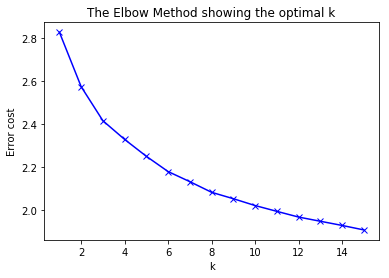

In [266]:
# Creating empty array to eventually store error costs from each k means model
error_cost = []

#For loop to fit models with 1-15 clusters
for i in range(1,16):
    km = KMeans(n_clusters = i, algorithm = "auto", random_state=1234) #Specifying the k means model with i=1 to i=15 clusters
    km.fit(eclsk_input) #Fitting the specified k means to the input data
    #Line below is to add error_cost from given model to array
    error_cost.append(sum(np.min(cdist(eclsk_input, km.cluster_centers_, 'euclidean'), axis=1)) / eclsk_input.shape[0])

#Viewing the error cost from each model
error_cost

#Setting number of clusters (1-15) for purpose of plotting and storing in variable n_clust
n_clust = range(1,16)

#Creating the plot
plt.plot(n_clust, error_cost, 'bx-')
#Labeling Xaxis as 'k'
plt.xlabel('k')
#Labeling Yaxis as 'Error Cost'
plt.ylabel('Error cost')
#Giving title to plot
plt.title('The Elbow Method showing the optimal k')
#Displaying thee plot
plt.show()

#Took inspiration from code in Lecture 11
#Also consulted https://pythonprogramminglanguage.com/kmeans-elbow-method/

Although there is some ambiguity in the above graph, I see an inflection point after k=3, meaning that starting at k=4, the reduction in error cost becomes minimal. Thus, a good value for k is 3. Using this information below, I retain the model for k=3. I then loop through the variables in the input dataframe to show a set of graphs of each of the k means clusters for k=3 for each input category against each other input category using a different color for each of the 3 clusters. The purpose is to visually confirm that k=3 is a good choice for the number of clusters.

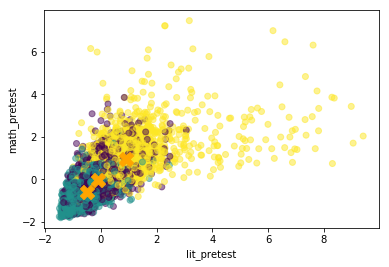

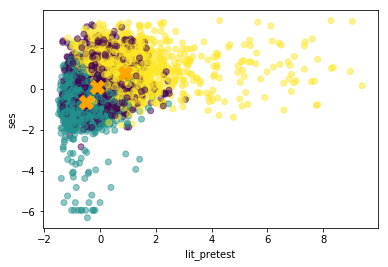

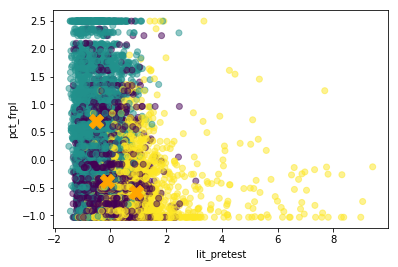

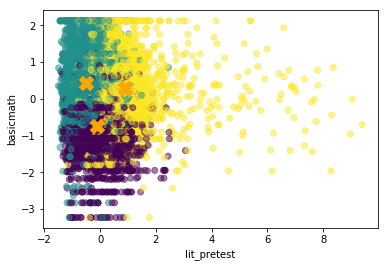

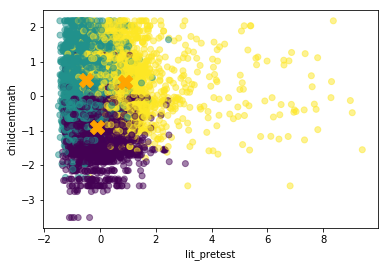

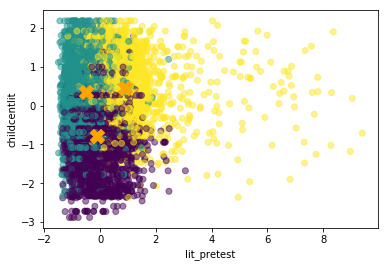

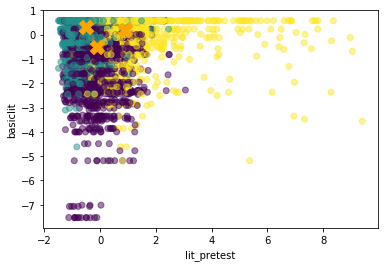

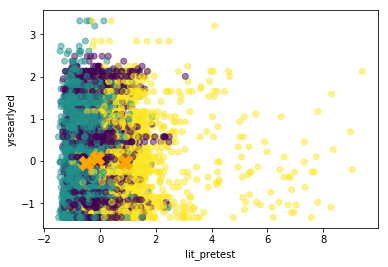

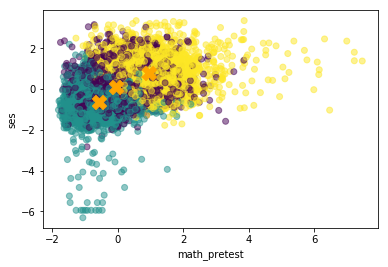

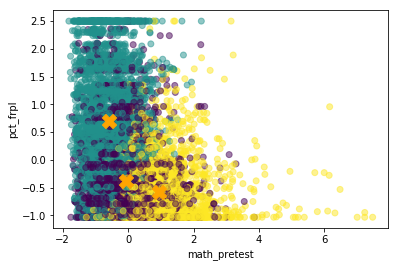

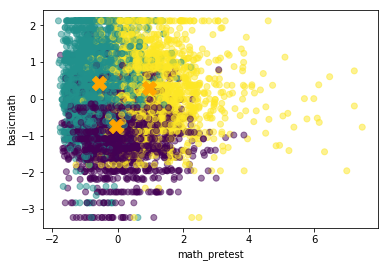

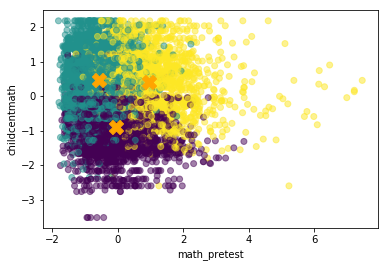

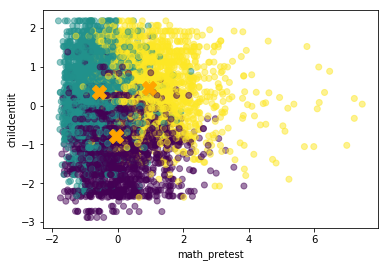

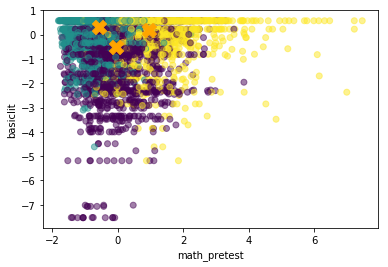

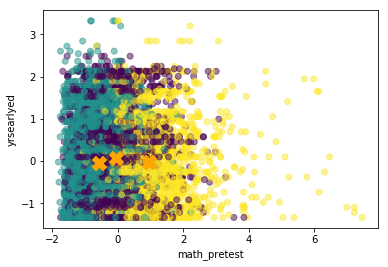

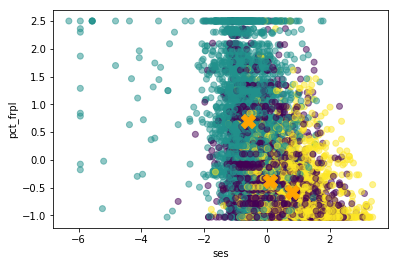

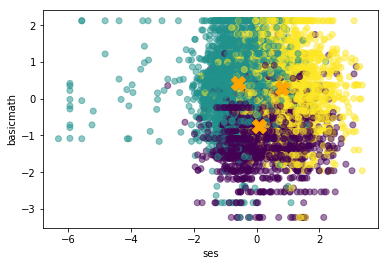

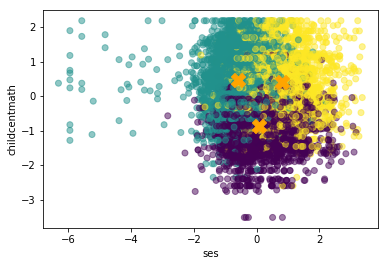

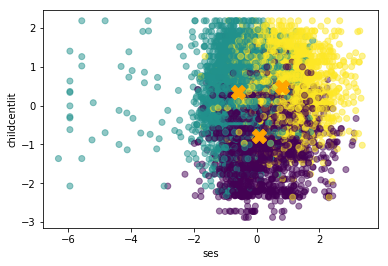

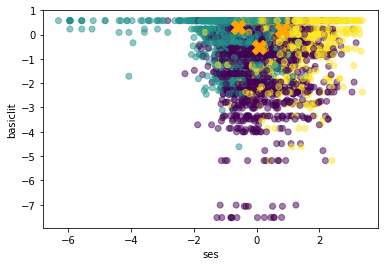

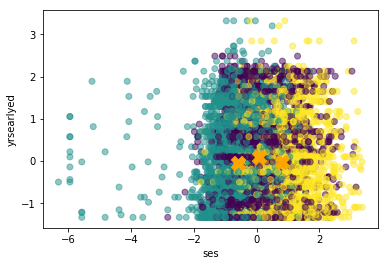

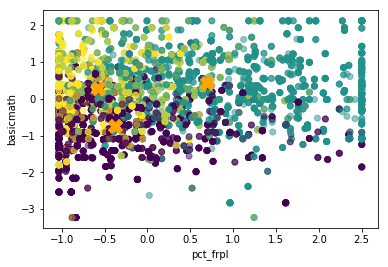

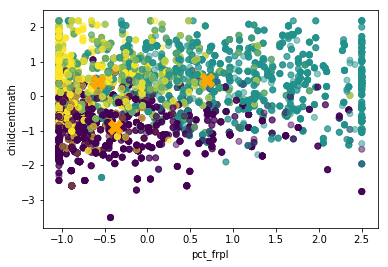

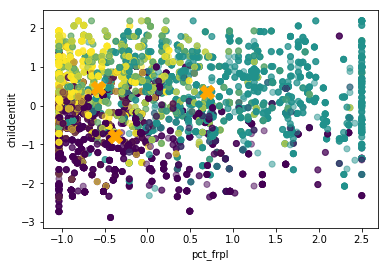

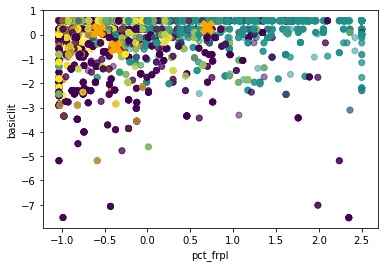

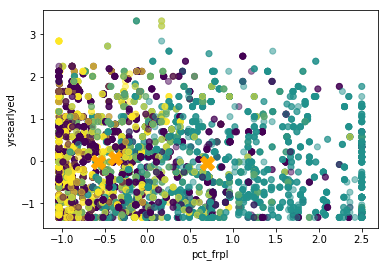

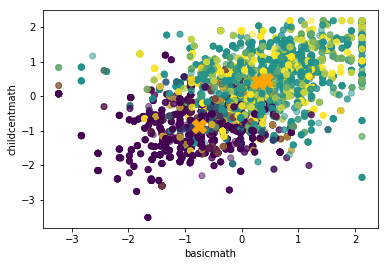

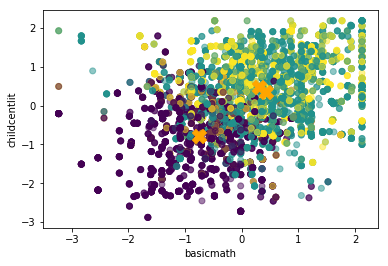

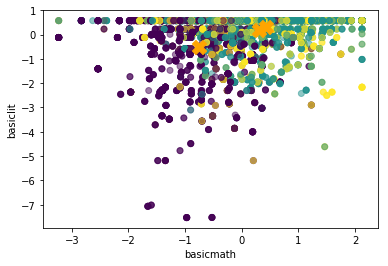

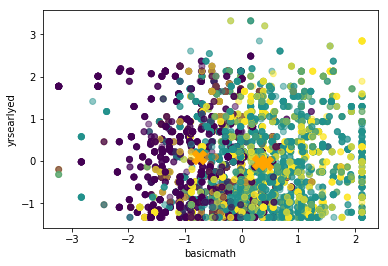

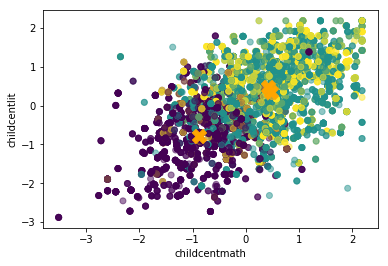

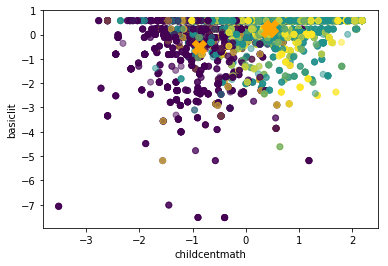

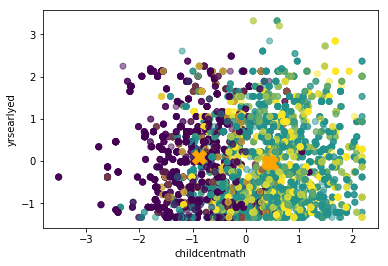

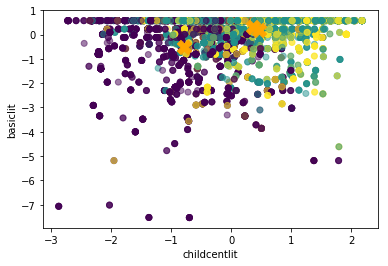

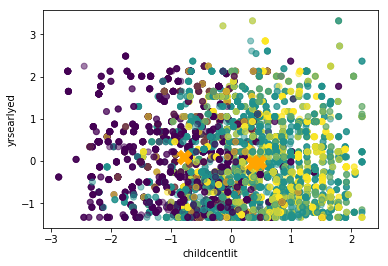

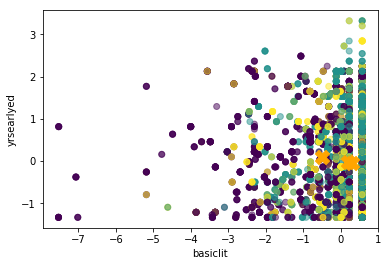

In [267]:
#Running K means again with number of clusters = 3
km = KMeans(n_clusters = 3, algorithm = "auto")
km.fit(eclsk_input)

#Find the clusters and assign each data to a cluster
labels = km.predict(eclsk_input)

#Making labels from K means part of dataframe
eclsk_input['labels']=labels

#Assign the cluster centers
centroids = km.cluster_centers_.squeeze()

#Setting x and y to equal 2 different columns in eclsk_input dataframe, changing up which ones they are using for loop
#Setting i to run through each column number minus 1 (leaving off last column -- so 0 to 13)--will be x's for graphs
for i in range(0,8):
    #Setting j to run through each column number starting at 1 more than whatever i (x for graph) is
    for j in range((i+1),9):
        x = eclsk_input.iloc[:,i]
        y = eclsk_input.iloc[:,j]
        colname_x = eclsk_input.columns[i]
        colname_y = eclsk_input.columns[j]
        #Scatterplot with cluster labels
        plt.scatter(x,y, c = labels, alpha = 0.5)
        #Assign the centroid columns
        c_x = centroids[:,i]
        c_y = centroids[:,j]
        #Make a scatter plot of the centroids, type, size, color of centroid markers
        plt.scatter(c_x,c_y, marker='X', s = 200,color='orange', )
        #Label the plot axes
        plt.xlabel(colname_x)
        plt.ylabel(colname_y)
        plt.show()



#Took inspiration from code in Lecture 11

In some of the scatterplots above, the clusters are visually clear and somewhat separate from each other. In others, they look much less clear. Some of the problem with the visualization of the clusters may have to do with the large size of the sample. So my next task is to repeat the same visualizations but with a random sample of 300 students.

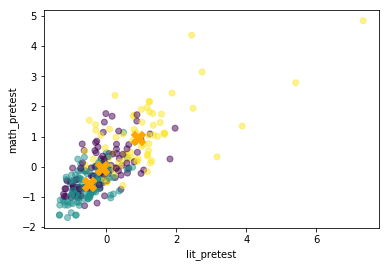

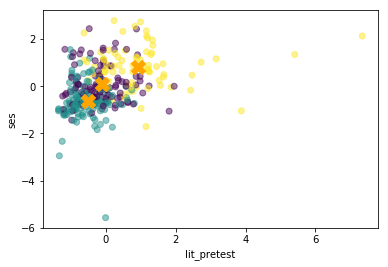

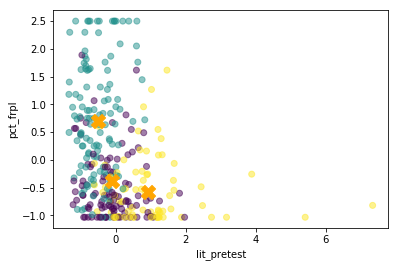

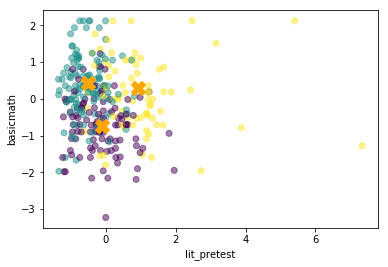

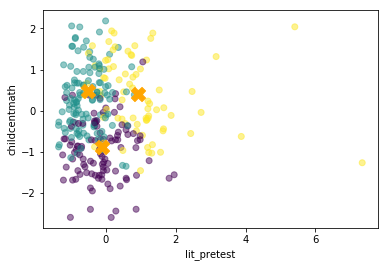

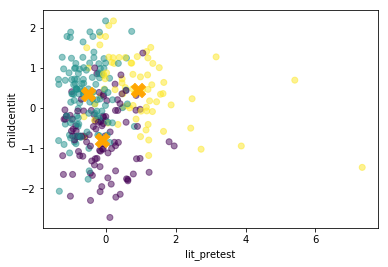

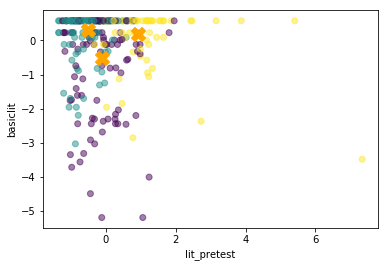

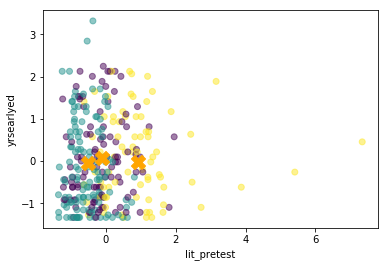

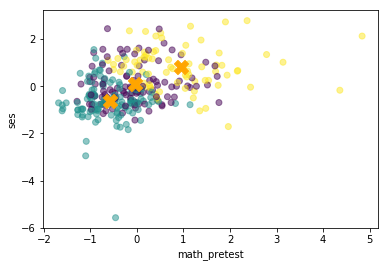

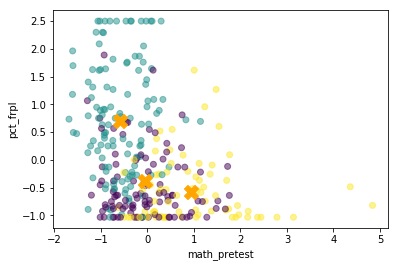

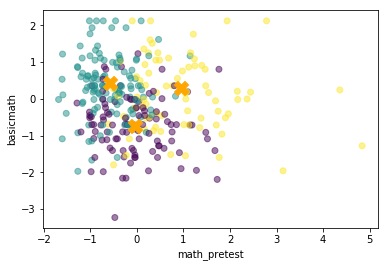

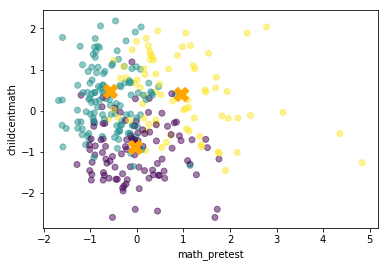

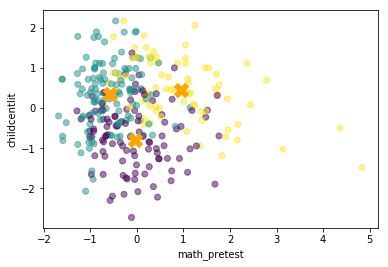

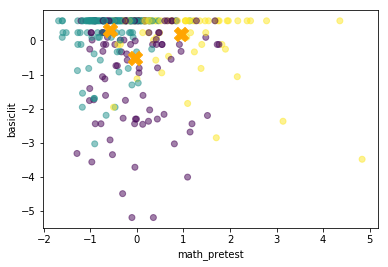

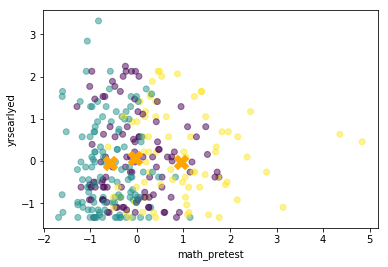

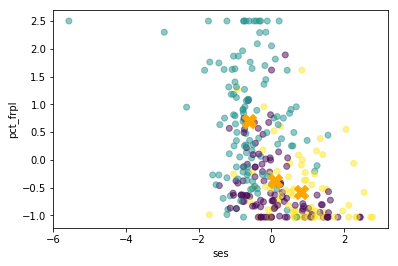

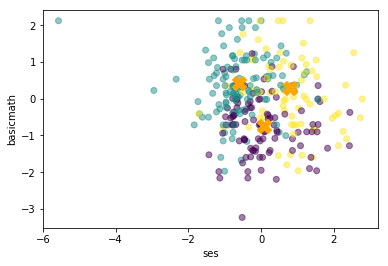

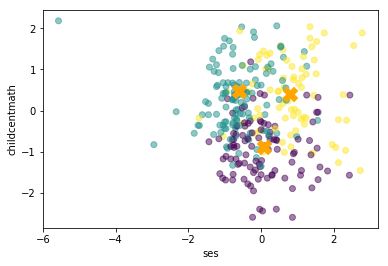

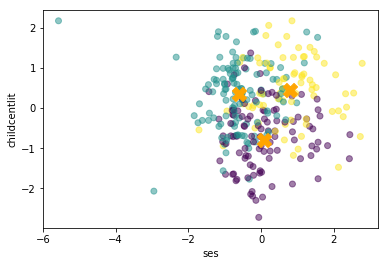

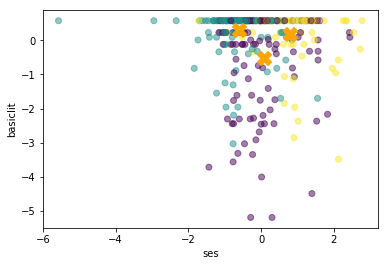

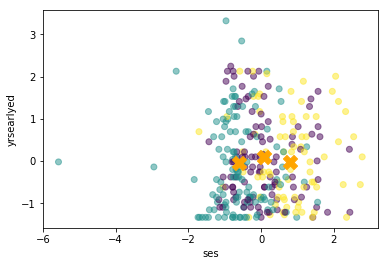

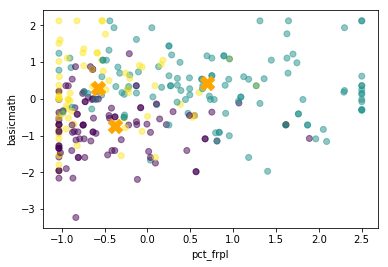

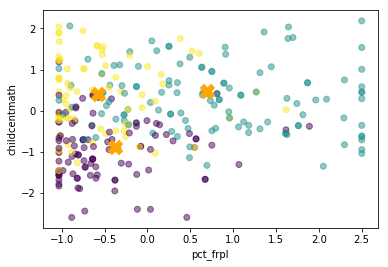

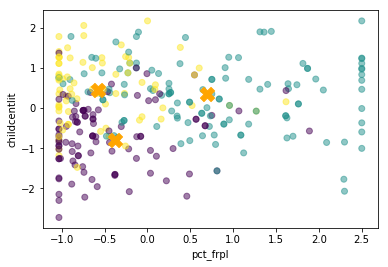

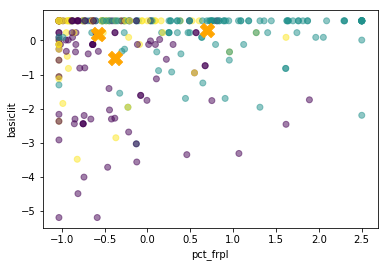

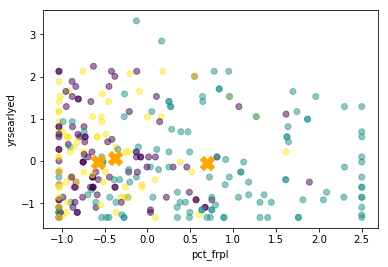

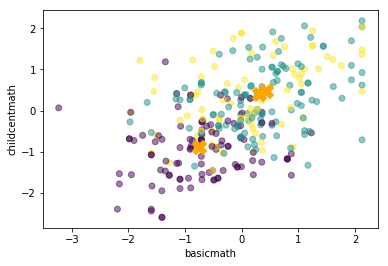

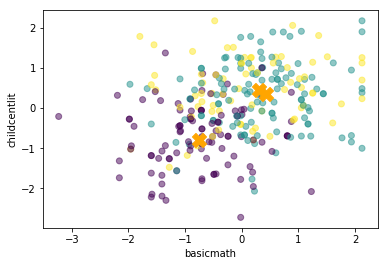

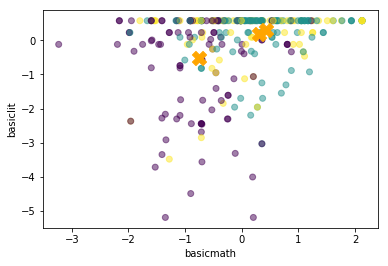

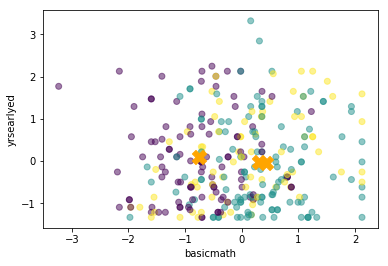

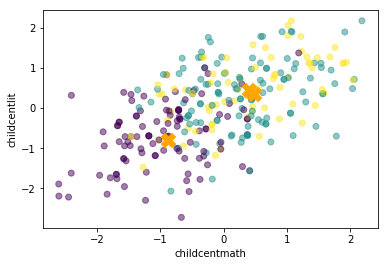

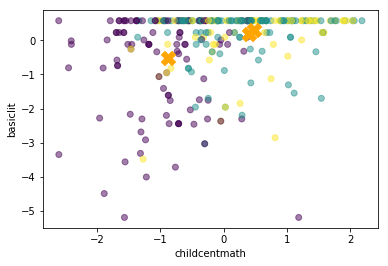

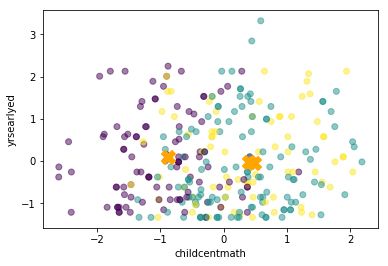

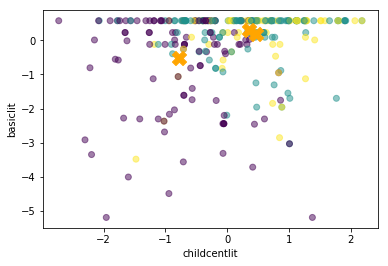

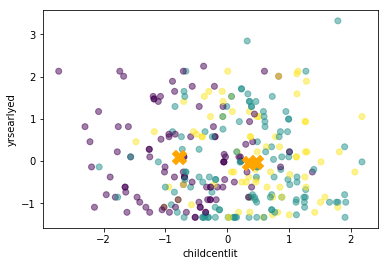

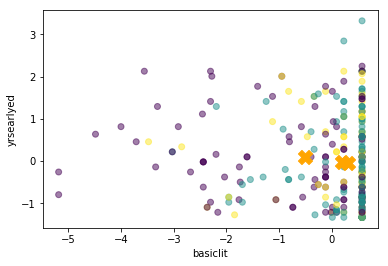

In [268]:
#Taking random sample of 300 students
eclsk_input_rand=eclsk_input.sample(n=300, random_state=1234)

#Setting x and y to equal 2 different columns in eclsk_input dataframe, changing up which ones they are using for loop
#Setting i to run through each column number minus 1 (leaving off last column -- so 0 to 13)--will be x's for graphs
for i in range(0,8):
    #Setting j to run through each column number starting at 1 more than whatever i (x for graph) is
    for j in range((i+1),9):
        x = eclsk_input_rand.iloc[:,i]
        y = eclsk_input_rand.iloc[:,j]
        colname_x = eclsk_input_rand.columns[i]
        colname_y = eclsk_input_rand.columns[j]
        #Scatterplot with cluster labels
        plt.scatter(x,y, c = eclsk_input_rand['labels'], alpha = 0.5)
        #Assign the centroid columns
        c_x = centroids[:,i]
        c_y = centroids[:,j]
        #Make a scatter plot of the centroids, type, size, color of centroid markers
        plt.scatter(c_x,c_y, marker='X', s = 200, color='orange', )
        #Label the plot axes
        plt.xlabel(colname_x)
        plt.ylabel(colname_y)
        plt.show()



#Took inspiration from code in Lecture 11

Taking a random sample helps to show that, though the clusters still appear to be clearer for some variables than for others, the clusters formed by K means seem to be capturing some meaningful groupings among the students in our data. Before doing anything more with the cluters created above, compute means of each input variable according to the clusters to get a sense of the characteristics of each cluster.

In [269]:
#Now get some descriptive statistics on the clusters created by K means
descriptives_bycluster = eclsk_input.groupby(by=['labels'], as_index=True).mean()
print(descriptives_bycluster)

        lit_pretest  math_pretest       ses  pct_frpl  basicmath  \
labels                                                             
0         -0.114288     -0.053279  0.084559 -0.374182  -0.746377   
1         -0.507577     -0.579828 -0.604252  0.693229   0.431907   
2          0.913514      0.945295  0.807008 -0.573435   0.295291   

        childcentmath  childcentlit  basiclit  yrsearlyed  
labels                                                     
0           -0.881954     -0.788906 -0.502620    0.082786  
1            0.472911      0.355642  0.301020   -0.053106  
2            0.405609      0.464789  0.183464   -0.024883  


The above gives us the sense that:
Cluster 0 has about average (or slightly below) performance on the math and literacy pre-tests, is of average socio-economic status, and received lower than average frequency for the teaching approaches captured by the variables basicmath, childcentmath, childcentlit, and basiclit. These students tend to be in schools with low percenatages of free and reduced-price lunch (meaning that the schools have somewhat more affluent students). Teachers for these students, however, have above average levels of experience teaching early education. 

Cluster 1 has performance on the math and literacy pre-tests that is well below average and is also well below average in terms of socio-economic status. In line with this, they attend schools with higher percenatages of students receiving free and reduced-price lunch (meaning that their schools serve less affluent students). Their teachers have use the teaching approaches at well above average frequencies but have somewhat lwer than average amounts of experience teaching early education.

Cluster 2 tends to be very high performing on math and literacy pretests. They generally have well above average socio-economic status and, relatedly, attend schools that serve a relatively low percentage of free and reduced-price lunch students (i.e., students at their schools tend to be more affluent). Their teachers use the teaching approaches at frequencies that a somewhat above average to well above average but have relatively less experience teaching in early education.

Now that I have my clusters and have a sense of what the clusters are telling us about the students that belong to them, I can combine the information on which cluster each student is in with the "output" data to see how my clusters perform in predicting student outcomes on post-tests. I also do some exploration of the groups below.

C:\Users\tchiatovich\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


cluster_0    0.335922
cluster_1    0.399871
cluster_2    0.264207
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          math_posttest   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     1495.
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        19:50:12   Log-Likelihood:                -9697.3
No. Observations:                7725   AIC:                         1.940e+04
Df Residuals:                    7722   BIC:                         1.942e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

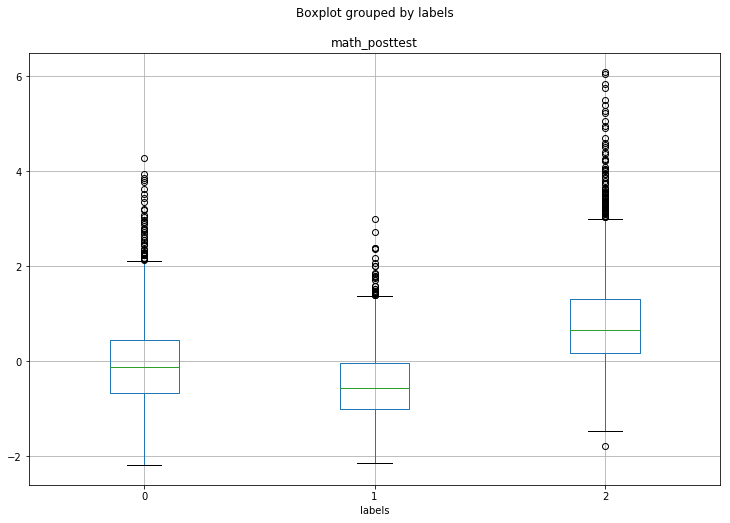

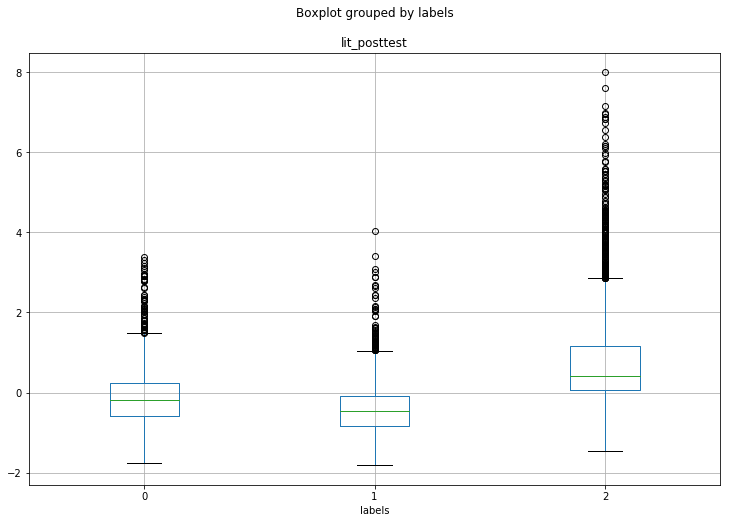

In [270]:
#Putting the labels together with the output data
eclsk_output['labels']=labels

#Create a boxplot for math_posttest
eclsk_output.boxplot('math_posttest', by='labels', figsize=(12, 8))

#Create a boxplot for lit_posttest
eclsk_output.boxplot('lit_posttest', by='labels', figsize=(12, 8))

#Manipulating the data in preparation for running the regression--getting indicator/dummy variables for groups
eclsk_output_dummies=pd.concat([eclsk_output.drop('labels', axis=1), pd.get_dummies(eclsk_output['labels'], prefix='cluster')], axis=1)

#Getting averages for the indicator/dummy variables to get the proportion of students in each group
proportions_bycluster = eclsk_output_dummies[['cluster_0', 'cluster_1', 'cluster_2']].mean()
print(proportions_bycluster)

# Fit regression model for math 
results_math = smf.ols('math_posttest ~ cluster_1 + cluster_2', data=eclsk_output_dummies).fit()

# Inspect the results
print(results_math.summary())

# Fit regression model for literacy 
results_lit = smf.ols('lit_posttest ~ cluster_1 + cluster_2', data=eclsk_output_dummies).fit()

# Inspect the results
print(results_lit.summary())

#Consulted https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/
#Also consulted https://stackoverflow.com/questions/23208745/python-pandas-add-dummy-columns-to-the-original-dataframe
#And https://www.statsmodels.org/stable/index.html


The means of the indicator/dummy variables for the clusters tell us that about 34% of students are in cluster 0, 40% are in cluster 1, and the remaining 26% are in cluster 2. The boxplots suggest that cluster 2 scores the highest on the post-tests overall while cluster 1 scores the lowest, with cluster 0 being somewhere in the middle (but closer to cluster 1 than cluster 2) in math. In literacy, the same trend generally appears to be true, though visually cluster 0 appears to be quite similar to cluster 1 and is only slightly higher in terms of its literacy post-test scores. Note that for both literacy and math post-tests, the boxplots have long tails on the positive side of the plots. Using cluster 0 as the reference category (left out of the linear regression models, meaning that coefficients for clusters 1 and 2 are in comparison to cluster 0), we see from the regression results that:
1. On the math post-test, students in cluster 1 scored 0.44 standard deviation unit lower than students in cluster 0 on average, and that difference was highly statistically significant. Students in cluster 2 scored .88 standard deviation unit higher than students in cluster 0 on average, and again, that difference was highly statistically significant.
2. On the literacy post-test, students in clsuter 1 scored .27 standard deviation unit lower than students in cluster 0 on average, and, as with math, that difference was highly statistically signiciant. Again similar to the results for math, students in cluster 2 scored .96 standard deviation units higher than students in cluster 0 on average, with that difference being highly statistically significant.

The clustering therefore provided us with useful information regarding student skills at the end of their kindergarten year. Although the R-squared statistics for the models (.28 and .25 for math and literacy respectively) weren't particularly large, the fact that we were able to explain roughly a quarter of the variance in post-test scores basedon solely on two indicator/dummy variables in the model is impressive. And it has important policy implications. The clusters could form the basis for principals or teachers to design an intervention for students to hopefully boost their year-end skills.